# Deep Learned Representations: A GON-Based Approach

In the previous module, we adopted a GAIA-based method for representing audio signals. In this notebook, we provide an alternative technique involving gradient origin networks (GONs). More information regarding this novel generative model can be found by accessing [this paper](https://arxiv.org/abs/2007.02798) and/or by clicking [here](https://cwkx.github.io/data/GON/).

The structure for this module will be as follows. We will apply the GON-based approach to the macaque coo dataset in order to train a GON to reconstruct coo spectrograms. After training, we will encode the STFT inputs into the latent space and carry out a number of dimensionality reduction schemes to visualize the data. Lastly, we will explore numerous metrics in an effort to quantify the goodness of our representations.

The following will be implemented in PyTorch, but we provide a conversion to Tensorflow (which will need to be refined) as an appendix.

# Imports, Constants, and GPU

We'll start off by maing sure that the GPU is enabled, and then we'll proceed with a number of imports.

In [1]:
import tensorflow as tf
with tf.device('/GPU:0'):
    print('GPU enabled')
tf.config.list_physical_devices()

GPU enabled


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import numpy as np

from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import sleep

import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf

import tensorflow as tf

from fastai2.vision.all import *

import pathlib
from IPython.display import Audio

import re
from sklearn.model_selection import train_test_split

import librosa
from scipy import interpolate
import scipy.signal

import functools
import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

import warnings
warnings.simplefilter('ignore', RuntimeWarning)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchsummary import summary

In [6]:
SR = 24414
NFFT = 1024
HOP_LENGTH = None
WINDOW = scipy.signal.hanning
DB_TH = 1e-4
RES = 64
FMAX = 7500
BATCH_SIZE = 32
LATENT_DIM = 128
MAX = 1
MIN = 0
URL = 'https://storage.googleapis.com/ml-animal-sounds-datasets/macaques_24414Hz.zip'

# Preparing the Data

We'll use a similar framework for preparing the data (constructing the training sets) as in the previous module, so we won't expound the approach here.

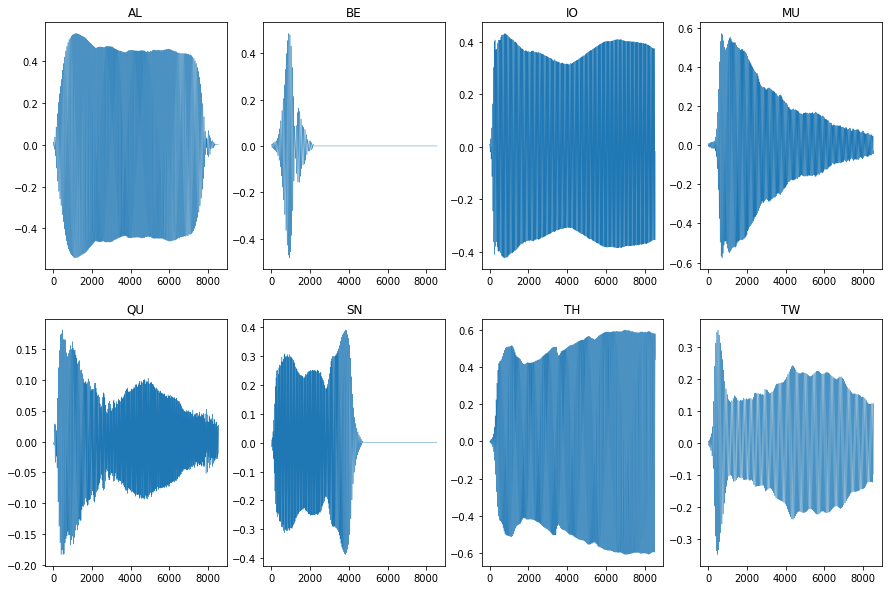

In [7]:
class LoadData(object):
    
    def __init__(self, url=URL):
        self.url = url
        
    def construct_dataframe(self):
        path = untar_data(self.url)
        wav_files = get_files(path)

        wfs = []
        labels = []
        wavs = []

        for wav in wav_files:
            call_code = re.split('/', str(wav))[-2]
            wf, _ = sf.read(wav)

            wfs.append(wf)
            labels.append(call_code)
            wavs.append(wav)

        call_dict = {l: i for i, l in enumerate(np.unique(labels))}
        call_category = [call_dict[i] for i in labels]
        data_df = pd.DataFrame({'Waveform':wfs, 'Path': wavs, 'Label': labels, 'Category': call_category})
        
        return data_df
    
    def fixed_dataframe(self):
        
        dataframe = self.construct_dataframe()
        
        mean_dur = self.get_mean_duration(dataframe)
        paths = dataframe.Path.values
        labels = dataframe.Label.values
        categories = dataframe.Category.values
        waveforms = dataframe.Waveform.values

        xs = []
        for wf in waveforms:
            x = librosa.util.fix_length(wf, mean_dur)
            xs.append(x)
        fixed_df = pd.DataFrame({'Waveform':xs, 'Path': paths, 'Label':labels, 'Category':categories})    
        return fixed_df
    
    def balanced_dataframe(self):
    
        dataframe = self.fixed_dataframe()
        balanced_df = dataframe.groupby('Category')
        balanced_df = balanced_df.apply(lambda x: x.sample(balanced_df.size().min()).reset_index(drop=True))

        return balanced_df
    
    def visualize_classes(self, dataframe, group='Label'):
        df = dataframe.groupby(group).apply(lambda x: x.sample(1))
        df = df.reset_index(drop=True)

        fig, axes = plt.subplots(2,4, figsize=(15,10))
        for i, ax in enumerate(axes.flatten()):
            ax.plot(df.Waveform.iloc[i], linewidth=0.4)
            ax.set_title(df.Label.iloc[i])
        plt.show()
    
    @staticmethod
    def get_mean_duration(dataframe):
        waveforms = dataframe.Waveform.values
        durs = []
        for wf in waveforms:
            durs.append(wf.shape[0])
        mean_dur = int(np.mean(durs))
        return mean_dur
    
loader = LoadData()
data_df = loader.balanced_dataframe()
mean_dur = loader.get_mean_duration(data_df)
loader.visualize_classes(data_df)

In [8]:
MEAN_DURATION = mean_dur
WINDOW_WIDTH = MEAN_DURATION

In [9]:
X_numpy = np.zeros((len(data_df), MEAN_DURATION), dtype=np.float32)
for i, wf in enumerate(data_df.Waveform.values):
    X_numpy[i, :] = wf
Y=data_df.Category.values

X_train, X_test, Y_train, Y_test = train_test_split(X_numpy, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2995, 8549), (749, 8549), (2995,), (749,))

## Constructing the Spectrograms

We'll now construct spectrograms using a custom spectrogram builder model. An advantage of using this technique is that we can choose to integrate the data preprocessing directly into the model architecture.

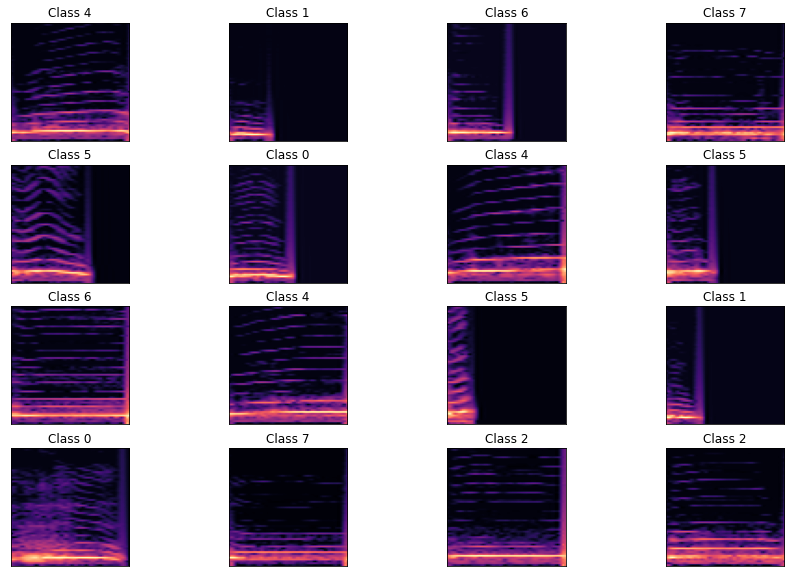

In [10]:
class Spectrogram(object):
    
    def __init__(self, sr=SR, nfft=NFFT, hop_length=HOP_LENGTH, window=WINDOW, db_th=1e-3, res=RES):
        self.sr = sr
        self.nfft = nfft
        self.hop_length = hop_length
        self.window = window
        self.db_th = db_th
        self.res = res
        
    def generate_representation(self, waveforms):
        batch_size= waveforms.shape[0]
        reps = np.zeros((batch_size, self.res, self.res))
        for n in range(batch_size):
            t, f, Sxx = self.construct_spectrogram(waveforms[n,:], 
                                                   sr=self.sr, 
                                                   nfft=self.nfft, 
                                                   hoplength = self.hop_length,
                                                   win=self.window, 
                                                   db_th=self.db_th)
            rep, _, _ = self.interp_spectrogram(Sxx, t, f, self.res)
            reps[n, :, :] = rep
        return reps.astype('float32')
    
    @staticmethod
    def construct_spectrogram(signal, sr, nfft, hoplength, win, db_th):
        #if hoplength is None:
        #    hoplength = nfft//16

        _, _, spec = librosa.reassigned_spectrogram(y=signal, sr=sr, n_fft=nfft, hop_length=hoplength, window=win)
        spec_db = librosa.power_to_db(spec, amin=db_th)
        f_bins = librosa.core.fft_frequencies(sr=sr, n_fft=nfft)
        t_bins = np.linspace(0, len(signal)/sr, spec[0].shape[0])
        return t_bins,f_bins, spec_db
    
    @staticmethod
    def interp_spectrogram(spec, t, f, res, fmax=FMAX):
        if fmax is None:
            fmax = np.max(f)
            
        interp_fx = interpolate.interp2d(t, f, spec, kind='cubic')
        ts_interp = np.linspace(np.min(t), np.max(t), res)
        freqs_interp = np.linspace(np.min(f), fmax, res)
        spec_interp = interp_fx(ts_interp, freqs_interp)
        return spec_interp, freqs_interp, ts_interp
    
    def vis_rep(self, X_examples, Y_examples):
        N_examples = X_examples.shape[0]

        def is_sqrt(x):
            sq = np.sqrt(x)
            return (sq - np.floor(sq))==0

        if ~is_sqrt(N_examples):
            raise ValueError('Choose a perfect square number of examples')
        else:
            plot_dim = int(np.sqrt(N_examples))

        reps = self.generate_representation(X_examples)
        fig, axes = plt.subplots(plot_dim, plot_dim, figsize=(15, 10))
        axs = axes.flatten()
        for n in range(N_examples):
            axs[n].imshow(reps[n, :, :], cmap='magma')
            axs[n].invert_yaxis()
            axs[n].set_xticks([])
            axs[n].set_yticks([])
            axs[n].set_title(f'Class {Y_examples[n]}')
        return 
    
spectrogram = Spectrogram()
specs = spectrogram.generate_representation(X_train[0:9])
spectrogram.vis_rep(X_train[0:16], Y_train[0:16])

In [11]:
class PreProcessShape(nn.Module):
    def __init__(self):
        super(PreProcessShape, self).__init__()
        self.preprocess = self.preprocess_shape
    
    def forward(self, x):
        return self.preprocess(x)
    
    @staticmethod
    def preprocess_shape(x, shape=WINDOW_WIDTH):
        x = torch.tensor(x)
        output = x.view(-1, shape)
        return output

In [12]:
class SpecGram(nn.Module):
    def __init__(self):
        super(SpecGram, self).__init__()
        self.spectrogram = Spectrogram().generate_representation

    def forward(self, x):
        return torch.tensor(self.spectrogram(x.numpy()))

In [13]:
class MinMaxScaler(nn.Module):
    def __init__(self):
        super(MinMaxScaler, self).__init__()
        
    def forward(self, x):
        _min = torch.min(x, axis=2, keepdim=True).values
        _min = torch.min(_min, axis=1, keepdim=True).values
        
        _max = torch.max(x, axis=2, keepdim=True).values
        _max = torch.max(_max, axis=1, keepdim=True).values
        
        x_norm = (x - _min) / (_max - _min)
        return x_norm

In [14]:
class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()
        
    def forward(self, x):
        return x.unsqueeze(1)

Let's construct a spectrogram generator as a ``Sequential`` model in PyTorch and see how it works.

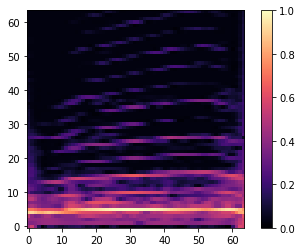

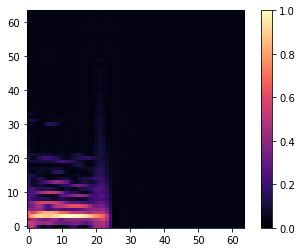

In [15]:
spectrogram_builder = nn.Sequential(PreProcessShape(), SpecGram(), MinMaxScaler(), Reshape())
specs = spectrogram_builder(X_train[0:2])
plt.imshow(specs[0, 0, :, :], cmap='magma')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()
plt.imshow(specs[1, 0, :, :], cmap='magma')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [16]:
X_train_specs = spectrogram_builder(X_train)
Y_train_specs = torch.Tensor(Y_train)
X_train_specs.shape, Y_train_specs.shape

(torch.Size([2995, 1, 64, 64]), torch.Size([2995]))

In [17]:
train_dataset = torch.utils.data.TensorDataset(X_train_specs, Y_train_specs)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

# Building the GON

We are now ready to start building the GON. For simplicity, we'll adapt the code from [this GitHub repo](https://github.com/cwkx/GON) with a few modifications. We begin with a few constant definitions.

In [21]:
IMG_SIZE = RES
N_CHANNELS = 1
IMG_COORDINATES = 2

LR = 1e-4
HIDDEN_FEATURES = 256
N_LAYERS = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


## Model Architecture

In [19]:
class SirenLayer(nn.Module):
    def __init__(self, in_f, out_f, w0=30, is_first=False, is_last=False):
        super().__init__()
        self.in_f = in_f
        self.w0 = w0
        self.linear = nn.Linear(in_f, out_f)
        self.is_first = is_first
        self.is_last = is_last
        self.init_weights()
    
    def init_weights(self):
        b = 1 / self.in_f if self.is_first else np.sqrt(6 / self.in_f) / self.w0
        with torch.no_grad():
            self.linear.weight.uniform_(-b, b)

    def forward(self, x):
        x = self.linear(x)
        return x if self.is_last else torch.sin(self.w0 * x)

In [20]:
def GON(dimensions):
    first_layer = SirenLayer(dimensions[0], dimensions[1], is_first=True)
    other_layers = []
    for dim0, dim1 in zip(dimensions[1:-2], dimensions[2:-1]):
        other_layers.append(SirenLayer(dim0, dim1))
    final_layer = SirenLayer(dimensions[-2], dimensions[-1], is_last=True)
    return nn.Sequential(first_layer, *other_layers, final_layer)

## Helper Functions

In [22]:
def get_mgrid(sidelen, dim=2):
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

In [23]:
train_iterator = iter(cycle(train_dataloader))

## Defining the Model

In [108]:
gon_shape = [IMG_COORDINATES+LATENT_DIM] + [HIDDEN_FEATURES]*N_LAYERS + [N_CHANNELS]
F = GON(gon_shape).to(DEVICE)

optim = torch.optim.Adam(lr=LR, params=F.parameters())
c = torch.stack([get_mgrid(IMG_SIZE, 2) for _ in range(BATCH_SIZE)]).to(DEVICE) # coordinates
recent_zs = []
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(F.parameters()))}')

> Number of parameters 231169


In [109]:
summary(F, (1, RES**2, LATENT_DIM+IMG_COORDINATES))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1         [-1, 1, 4096, 256]          33,536
        SirenLayer-2         [-1, 1, 4096, 256]               0
            Linear-3         [-1, 1, 4096, 256]          65,792
        SirenLayer-4         [-1, 1, 4096, 256]               0
            Linear-5         [-1, 1, 4096, 256]          65,792
        SirenLayer-6         [-1, 1, 4096, 256]               0
            Linear-7         [-1, 1, 4096, 256]          65,792
        SirenLayer-8         [-1, 1, 4096, 256]               0
            Linear-9           [-1, 1, 4096, 1]             257
       SirenLayer-10           [-1, 1, 4096, 1]               0
Total params: 231,169
Trainable params: 231,169
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.03
Forward/backward pass size (MB): 64.06
Params size (MB): 0.88
Estimated 

# Preparing to Train the Model

Now that we've built the GON, we'll define a few functions to visualize the training procedure. These include a function to plot the input spectrograms alongside the reconstructions, a function to plot the live training loss, and a function to visualize the latent space encoding.

In [110]:
x_example, y_example = next(train_iterator)

In [111]:
def gen_reconstruction(model, x):
    model.eval()
    
    x = x.to(DEVICE)
    x = x.permute(0, 2, 3, 1).reshape(BATCH_SIZE, -1, N_CHANNELS)
    z = torch.zeros(BATCH_SIZE, 1, LATENT_DIM).to(DEVICE).requires_grad_()
    z_rep = z.repeat(1,c.size(1),1)
    g = model(torch.cat((c, z_rep), dim=-1))
    L_inner = ((g - x)**2).sum(1).mean()
    z = -torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]
    
    z_rep = z.repeat(1, c.size(1), 1)
    recons = model(torch.cat((c, z_rep), dim=-1))
    recons = recons.reshape(-1, RES, RES).detach()
    return recons

In [112]:
def vis_reconstructions(x, x_recon, step, save=False):
    
    fig, axes = plt.subplots(4,4,figsize=(8,8))
    axs = axes.flatten()
    axs[0].set_title('Data')
    axs[1].set_title('Reconstruction')
    axs[2].set_title('Data')
    axs[3].set_title('Reconstruction')
    for i in range(8):
        axs[2*i].imshow((x[i].reshape(RES,RES)).detach().cpu().numpy(), cmap='magma', vmin=0, vmax=1)
        axs[2*i].invert_yaxis()
        axs[2*i].axis('off')
            
        axs[2*i+1].imshow(x_recon[i].detach().cpu().numpy(), cmap='magma', vmin=0, vmax=1)
        axs[2*i+1].invert_yaxis()
        axs[2*i+1].axis('off')
    
    if save:
        plt.savefig('Temporary_Animations/recon_step_{:04d}.png'.format(step))
        
    plt.show()

In [115]:
ITERATIONS = 3000
def plot_losses(L, step, iterations=ITERATIONS, save=False):
    fig = plt.figure(figsize=(7,4))
    plt.plot(L)
    plt.title('Training Loss')
    plt.xlim([0, iterations])
    plt.ylim([0, 100])
    plt.xlabel('Iteration')
    plt.ylabel('L2 Loss')
    
    if save:
        plt.savefig('Temporary_Animations/loss_step_{:04d}.png'.format(step))
        
    plt.show()

In [116]:
losses = []

# Training Loop

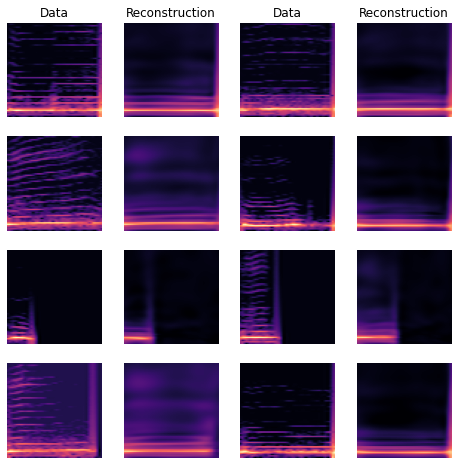

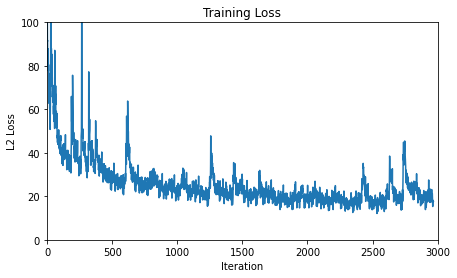

100%|██████████| 3000/3000 [1:40:57<00:00,  2.02s/it]


In [117]:
for step in tqdm.tqdm(range(ITERATIONS)):
    
    x, t = next(train_iterator)
    if x.shape[0] != BATCH_SIZE:
        continue
    x, t = x.to(DEVICE), t.to(DEVICE)
    x = x.permute(0, 2, 3, 1).reshape(BATCH_SIZE, -1, N_CHANNELS)

    z = torch.zeros(BATCH_SIZE, 1, LATENT_DIM).to(DEVICE).requires_grad_()
    z_rep = z.repeat(1,c.size(1),1)
    g = F(torch.cat((c, z_rep), dim=-1))
    L_inner = ((g - x)**2).sum(1).mean()
    z = -torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]

    z_rep = z.repeat(1, c.size(1), 1)
    g = F(torch.cat((c, z_rep), dim=-1))
    L_outer = ((g - x)**2).sum(1).mean()
    optim.zero_grad()
    L_outer.backward()
    optim.step()

    losses.append(L_outer.item())
    
    
    if step % 2 == 0:
        to_save = True
    else:
        to_save = False
        
    clear_output(wait=True)
    vis_reconstructions(x_example, gen_reconstruction(F, x_example), step, save=to_save)
    plot_losses(losses, step, save=to_save)

In [119]:
torch.save(F, '07_GON/GON_model')

Below is an animation demonstrating the reconstruction as a function of training iteration.

In [137]:
from IPython.display import HTML
HTML('<img src="07_Animations/MacaqueGON_Recon.gif">')

# Encoding Inputs to the Latent Space

Now that we have successfully trained our model we can proceed to generate the deep learned latent representation. We begin by defining the encoder, which performs a gradient descent step initialized at the origin to find the latent vector.

In [140]:
def encoder(model, x):
    model.cpu()
    model.eval()
    c_cpu = torch.stack([get_mgrid(IMG_SIZE, 2) for _ in range(BATCH_SIZE)]).to('cpu') # coordinates
    x = x.to('cpu')
    x = x.permute(0, 2, 3, 1).reshape(BATCH_SIZE, -1, N_CHANNELS)
    z = torch.zeros(BATCH_SIZE, 1, LATENT_DIM).to('cpu').requires_grad_()
    z_rep = z.repeat(1,c_cpu.size(1),1)
    g = model(torch.cat((c_cpu, z_rep), dim=-1))
    L_inner = ((g - x)**2).sum(1).mean()
    z = -torch.autograd.grad(L_inner, [z])[0].detach()
    return z

We'll now use the above function to encode the inputs.

In [141]:
n_train_batches = X_train_specs.shape[0] // BATCH_SIZE

In [142]:
for counter in tqdm.tqdm(range(n_train_batches)):
    x_b, y_b = next(train_iterator)
    if x_b.shape[0] != BATCH_SIZE:
        continue
    
    z_b = encoder(F, x_b)
    if counter == 0:
        z_latent = z_b
        y_latent = y_b
    else:
        z_latent = torch.cat((z_latent, z_b), dim=0)
        y_latent = torch.cat((y_latent, y_b), dim=0)

100%|██████████| 93/93 [08:58<00:00,  5.79s/it]


Let's compilethe inputs in the original spectrogram feature space, the inputs in the encoded latent space, as well as the inputs in the raw audio feature space.

In [143]:
z_l = np.squeeze(z_latent.detach().numpy())
y_l = y_latent.numpy()
z_l.shape, y_l.shape

((2944, 128), (2944,))

In [160]:
x_s = X_train_specs.squeeze().view(X_train_specs.shape[0], -1).numpy()
y_s = Y_train_specs.numpy()
x_s.shape, y_s.shape

((2995, 4096), (2995,))

In [158]:
x_a = X_train
y_a = Y_train
x_a.shape, y_a.shape

((2995, 8549), (2995,))

## Visualizing the Results

We can now use UMAP to reduce the dimensionality of these arrays. Let's define a function to do this.

In [153]:
def vis_feature_space(inputs, labels):
    umap_reducer = UMAP(n_components=3, random_state=42)
    umap_reducer.fit(inputs)
    z_embedded = umap_reducer.transform(inputs)

    fig = plt.figure(figsize=(10,7), frameon=False)
    ax = fig.add_subplot(111, projection='3d')
    ax.grid(False)
    ax.set_axis_off()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0,0,0)

    ax.scatter(z_embedded[:, 0], z_embedded[:, 1], z_embedded[:, 2], c=labels, cmap='gist_rainbow', s=8)
    ax.axis('off')
    plt.show()

We start with the original raw audio feature space:

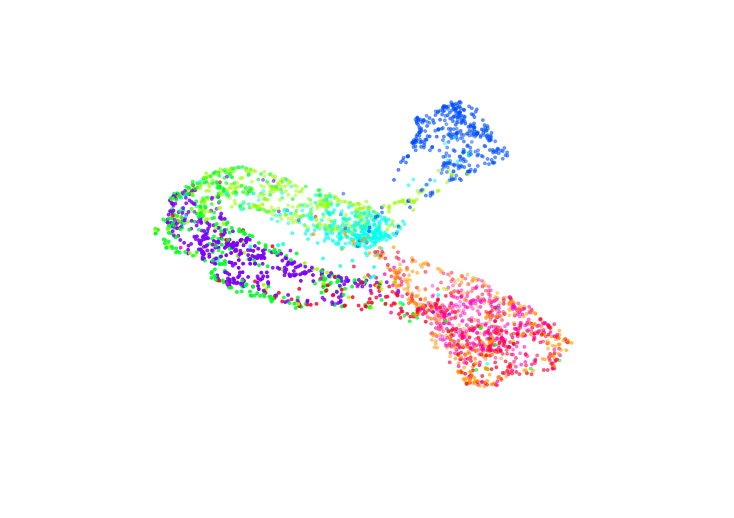

In [159]:
vis_feature_space(x_a, y_a)

Now for the spectrogram feature space:

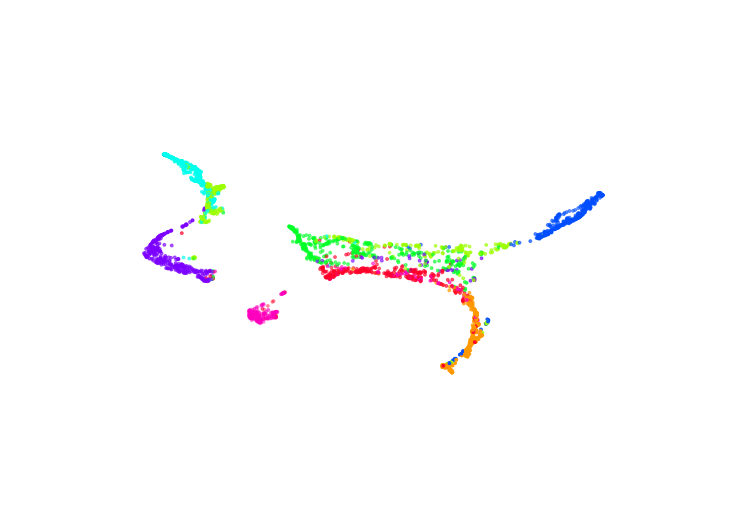

In [161]:
vis_feature_space(x_s, y_s)

And now the latent feature space:

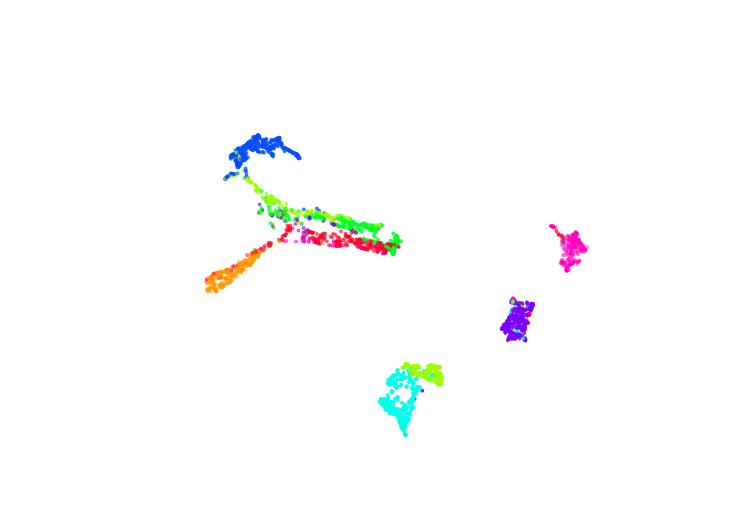

In [164]:
vis_feature_space(z_l, y_l)

We'll use one final high-dimensional data visualization technique involving Andrews curves.

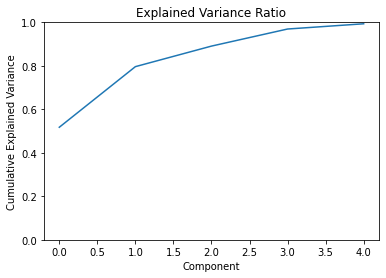

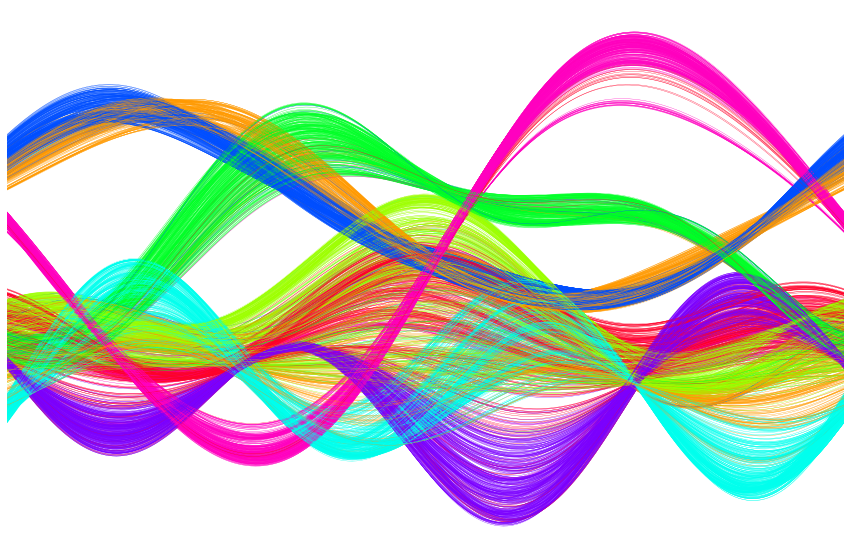

In [165]:
def visualize_reduced_vecs(X, Y, pca_components, umap_components=None, pca_var_vis=False, **kwargs):

    assert pca_components <= X.shape[1], 'PCA components greater than latent space dimensionality'
    
    if umap_components is not None:
        assert umap_components <= X.shape[1], 'UMAP components greater than latent space dimensionality'
        assert umap_components >= pca_components, 'UMAP components less than PCA components'
        
        umap_reducer = UMAP(n_components=umap_components, random_state=42)
        umap_reducer.fit(X)
        X = umap_reducer.transform(X)
    
    pca = PCA(n_components=pca_components)
    pca.fit(X)
    if pca_var_vis:
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.ylim([0, 1])
        plt.title('Explained Variance Ratio')
        plt.ylabel('Cumulative Explained Variance')
        plt.xlabel('Component')
        plt.show()
    X_embedded = pca.transform(X)
    
    embedded_df = pd.DataFrame(X_embedded)
    embedded_df['Class'] =  pd.Series(Y)
    
    plt.figure(figsize=(15,10))
    pd.plotting.andrews_curves(embedded_df, 'Class', colormap='gist_rainbow', linewidth=0.3)
    plt.axis('off')
    plt.gca().get_legend().remove()
    plt.show()
    
visualize_reduced_vecs(z_l, y_l, 5, umap_components=10, pca_var_vis=True)

Fantastic! We've demonstrated a few great ways to visualize our feature space. But how can we quantify the goodness of these representations?

# Assessing the Goodness of the Latent Representation

In previous modules, we evaluated the goodness of a representation by assessing the performance of downstream tasks using the various input representations. Here, we'll try to quantify the goodness from first principles in an unsupervised way.

A visual inspection of the above feature spaces seems to indicate the the latent representation yields improved clustering in terms of density and dispersion. Presumably, this might lead to enhanced classification with downstream tasks. We can use a variety of metrics available in the [scikit-learn package](https://scikit-learn.org/stable/modules/clustering.html) to carry out a quantitative cluster analysis. We'll start with an unsupervised approach using a k-means classifier, and then we'll move onto other metrics that require ground truth labels.

## Unsupervised Approach

### Silhouette Coefficients

Firstly, we'll use silhouette coefficients to analyze clustering in (1) the original spectrogram feature space, (2) a UMAP-embedded spectrogram feature space, (3) the latent feature space, and (4) a UMAP-embedded latent feature space.

In [168]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

In [175]:
def vis_silhouettes(inputs, N_classes=8, embed=False):
    km = KMeans(n_clusters=N_classes,
           init='k-means++',
           n_init=10,
           max_iter=300,
           tol=1e-4,
           random_state=42)
    
    if embed == True:
        umap_reducer_specs = UMAP(n_components=3, random_state=42)
        umap_reducer_specs.fit(inputs)
        inputs = umap_reducer_specs.transform(inputs)

    y_km = km.fit_predict(inputs)
    
    cluster_labels = np.unique(y_km)
    cmap = plt.cm.get_cmap('gist_rainbow', N_classes)
    cmaplist = [cmap(i) for i in range(cmap.N)]
    color_dict = {y:c for y,c in zip(np.unique(y_km), cmaplist)}

    n_clusters = cluster_labels.shape[0]
    sil_vals = silhouette_samples(inputs,
                                 y_km,
                                 metric='euclidean')
    
    y_ax_low, y_ax_up = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_sil_vals = sil_vals[y_km == c]
        c_sil_vals.sort()
        y_ax_up += len(c_sil_vals)

        color = color_dict[c]
        plt.barh(range(y_ax_low, y_ax_up),
                c_sil_vals,
                height=1.0,
                edgecolor='none',
                color=color)
        yticks.append((y_ax_low + y_ax_up) / 2.)
        y_ax_low += len(c_sil_vals)
    sil_avg = np.mean(sil_vals)
    plt.axvline(sil_avg,
               color='k',
               linestyle='--')
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette Coefficient')
    plt.show()

#### (1) Original Spectrogram Feature Space

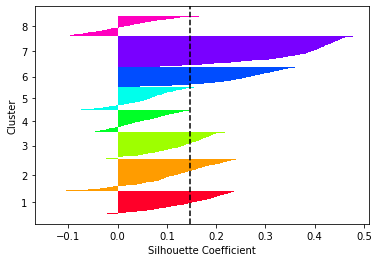

In [176]:
vis_silhouettes(x_s)

#### (2) UMAP-Embedded Spectrogram Feature Space

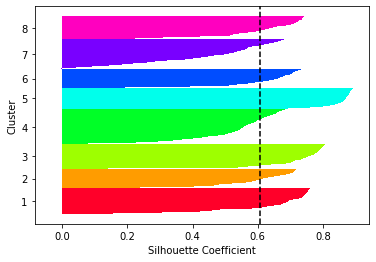

In [177]:
vis_silhouettes(x_s, embed=True)

#### (3) Latent Feature Space

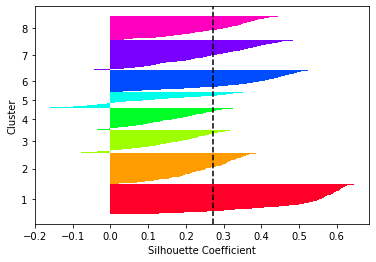

In [178]:
vis_silhouettes(z_l)

#### (4) UMAP-Embedded Latent Feature Space

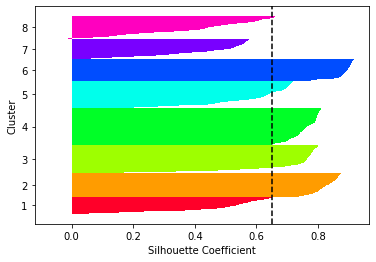

In [179]:
vis_silhouettes(z_l, embed=True)

Well that seems like the latent space does in fact provide a quantitative advantage in terms of clustering.

Let's explore a few other unsupervised methods.

### Other Unsupervised Approaches

In [185]:
def cluster_score(X_data, metric_fx, N_classes=8, embed=False):
    km = KMeans(n_clusters=N_classes,
           init='k-means++',
           n_init=10,
           max_iter=300,
           tol=1e-4,
           random_state=42)
    
    if embed == True:
        umap_reducer_specs = UMAP(n_components=3, random_state=42)
        umap_reducer_specs.fit(X_data)
        X_data = umap_reducer_specs.transform(X_data)
        
    y_pred = km.fit_predict(X_data)
    return metric_fx(X_data, y_pred)

#### Calinski-Harabasz Index (Higher is Better)

In [183]:
from sklearn.metrics import calinski_harabasz_score as ch_index

In [186]:
cluster_score(x_s, ch_index)

454.6398459865171

In [187]:
cluster_score(x_s, ch_index, embed=True)

9759.914076772298

In [188]:
cluster_score(z_l, ch_index)

1362.645654950461

In [189]:
cluster_score(z_l, ch_index, embed=True)

14907.882277107969

#### Davies-Bouldin Score (Closer to 0 is Better)

In [190]:
from sklearn.metrics import davies_bouldin_score as db_index

In [191]:
cluster_score(x_s, db_index)

2.1857823085698267

In [192]:
cluster_score(x_s, db_index, embed=True)

0.5349957270412212

In [193]:
cluster_score(z_l, db_index)

1.326440172548566

In [194]:
cluster_score(z_l, db_index, embed=True)

0.5415563229870493

These results imply that the latent representation *might* provide enhanced clustering. Let's move on to some external metrics that require groundtruth labels.

### External Metrics

In [202]:
def cluster_score(X_data, Y_data, metric_fx, N_classes=8, embed=False):
    km = KMeans(n_clusters=N_classes,
           init='k-means++',
           n_init=10,
           max_iter=300,
           tol=1e-4,
           random_state=42)
    
    if embed == True:
        umap_reducer_specs = UMAP(n_components=3, random_state=42)
        umap_reducer_specs.fit(X_data)
        X_data = umap_reducer_specs.transform(X_data)
        
    y_pred = km.fit_predict(X_data)
    
    return metric_fx(Y_data, y_pred)

#### Rand Index (Closer to 1 is Better)

In [203]:
from sklearn.metrics import adjusted_rand_score as rand_index

In [205]:
cluster_score(x_s, y_s, rand_index)

0.4634982216741319

In [206]:
cluster_score(x_s, y_s, rand_index, embed=True)

0.5609356433656099

In [207]:
cluster_score(z_l, y_l, rand_index)

0.4210893263878841

In [208]:
cluster_score(z_l, y_l, rand_index, embed=True)

0.6512593775136707

#### Mutual Info (Closer to 1 is Better)

In [209]:
from sklearn.metrics import adjusted_mutual_info_score as mutual_info

In [210]:
cluster_score(x_s, y_s, mutual_info)

0.5356697211888825

In [211]:
cluster_score(x_s, y_s, mutual_info, embed=True)

0.6547732641198246

In [212]:
cluster_score(z_l, y_l, mutual_info)

0.4930390301725131

In [213]:
cluster_score(z_l, y_l, mutual_info, embed=True)

0.7096032965764714

#### Homogeneity, Completeness and V-Measure (Closer to 1 is Better)

In [214]:
from sklearn.metrics import homogeneity_score as homogeneity
from sklearn.metrics import completeness_score as completeness
from sklearn.metrics import v_measure_score as vmeasure

In [215]:
cluster_score(x_s, y_s, homogeneity), cluster_score(x_s, y_s, completeness), cluster_score(x_s, y_s, vmeasure)

(0.5357719216928347, 0.5392619465546088, 0.5375112690586965)

In [216]:
cluster_score(x_s, y_s, homogeneity, embed=True), cluster_score(x_s, y_s, completeness, embed=True), cluster_score(x_s, y_s, vmeasure, embed=True)

(0.6527938973753142, 0.6595309173791973, 0.6561451146163392)

In [217]:
cluster_score(z_l, y_l, homogeneity), cluster_score(z_l, y_l, completeness), cluster_score(z_l, y_l, vmeasure)

(0.4925852673171685, 0.49761771137641275, 0.49508870131557153)

In [218]:
cluster_score(z_l, y_l, homogeneity, embed=True), cluster_score(z_l, y_l, completeness, embed=True), cluster_score(z_l, y_l, vmeasure, embed=True)

(0.7065659911972583, 0.7150413556025162, 0.7107784091094473)

While these results appear to agree with our visual inspection, it would be valuable to carry out a more thorough investigation of these metrics.

This concludes our discussion of GON-based approaches to latent space encoding.